In [4]:
pip install avalanche-lib==0.5

Note: you may need to restart the kernel to use updated packages.


# importation

In [1]:
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
import avalanche.checkpointing.checkpoint

import os
import json

# Correctly loading CIFAR10 and CIFAR100 datasets
train_cifar10 = CIFAR10(
    './data/cifar10', train=True, download=True, transform=torchvision.transforms.ToTensor()
)
test_cifar10 = CIFAR10(
    './data/cifar10', train=False, download=True, transform=torchvision.transforms.ToTensor()
)

train_cifar100 = CIFAR100(
    './data/cifar100', train=True, download=True, transform=torchvision.transforms.ToTensor()
)
test_cifar100 = CIFAR100(
    './data/cifar100', train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# Iterate over CIFAR100 dataset
for i, example in enumerate(train_cifar100):
    pass
print("Num. examples processed: {}".format(i + 1))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Num. examples processed: 50000


In [2]:
from avalanche.training.determinism.rng_manager import RNGManager
RNGManager.set_random_seeds(1234)

In [3]:
from typing import (
    List,
    Any,
    Sequence,
    Union,
    Optional,
    TypeVar,
    Callable,
    Dict,
    Tuple,
    Mapping,
    overload,
)

In [4]:
from avalanche.benchmarks.utils.utils import*
from typing import TypeVar, SupportsInt, Sequence, Protocol
from avalanche.benchmarks.utils.data import AvalancheDataset
from avalanche.benchmarks.utils.data_attribute import *

T_co = TypeVar("T_co", covariant=True)
TTargetType_co = TypeVar("TTargetType_co", covariant=True)
TTargetType = int

class IDataset(Protocol[T_co]):
    """
    Protocol definition of a Dataset.

    Note: no __add__ method is defined.
    """

    def __getitem__(self, index: int) -> T_co: ...

    def __len__(self) -> int: ...
        
class IDatasetWithTargets(IDataset[T_co], Protocol[T_co, TTargetType_co]):
    """
    Protocol definition of a Dataset that has a valid targets field.
    """

    @property
    def targets(self) -> Sequence[TTargetType_co]:
        """
        A sequence of elements describing the targets of each pattern.
        """
        ...
TClassificationDataset = TypeVar(
    "TClassificationDataset", bound="ClassificationDataset"
)        
class TaskAwareClassificationDataset(AvalancheDataset[T_co]):
    @property
    def task_pattern_indices(self) -> Dict[int, Sequence[int]]:
        """A dictionary mapping task ids to their sample indices."""
        return self.targets_task_labels.val_to_idx  # type: ignore

    @property
    def task_set(self: TClassificationDataset) -> TaskSet[TClassificationDataset]:
        """Returns the datasets's ``TaskSet``, which is a mapping <task-id,
        task-dataset>."""
        return TaskSet(self)

    def subset(self, indices):
        data = super().subset(indices)
        return data.with_transforms(self._flat_data._transform_groups.current_group)

    def concat(self, other):
        data = super().concat(other)
        return data.with_transforms(self._flat_data._transform_groups.current_group)

    def __hash__(self):
        return id(self)                
class TaskAwareSupervisedClassificationDataset(TaskAwareClassificationDataset[T_co]):
    # TODO: remove? ClassificationDataset should have targets
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert "targets" in self._data_attributes, (
            "The supervised version of the ClassificationDataset requires "
            + "the targets field"
        )
        assert "targets_task_labels" in self._data_attributes, (
            "The supervised version of the ClassificationDataset requires "
            + "the targets_task_labels field"
        )

    @property
    def targets(self) -> DataAttribute[TTargetType]:
        return self._data_attributes["targets"]

    @property
    def targets_task_labels(self) -> DataAttribute[int]:
        return self._data_attributes["targets_task_labels"]
        

class ISupportedClassificationDataset(IDatasetWithTargets[T_co, SupportsInt], Protocol):
    """
    Protocol definition of a Dataset that has a valid targets field (like the
    Datasets in the torchvision package) for classification.

    For classification purposes, the targets field must be a sequence of ints.
    describing the class label of each pattern.

    This class however describes a targets field as a sequence of elements
    that can be converted to `int`. The main reason for this choice is that
    the targets field of some torchvision datasets is a Tensor. This means that
    this protocol class supports both sequence of native ints and Tensor of ints
    (or longs).

    On the contrary, class :class:`IClassificationDataset` strictly
    defines a `targets` field as sequence of native `int`s.
    """

    @property
    def targets(self) -> Sequence[SupportsInt]:
        """
        A sequence of ints or a PyTorch Tensor or a NumPy ndarray describing the
        label of each pattern contained in the dataset.
        """
        ...
        
class TaskAwareSupervisedClassificationDataset(TaskAwareClassificationDataset[T_co]):
    # TODO: remove? ClassificationDataset should have targets
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert "targets" in self._data_attributes, (
            "The supervised version of the ClassificationDataset requires "
            + "the targets field"
        )
        assert "targets_task_labels" in self._data_attributes, (
            "The supervised version of the ClassificationDataset requires "
            + "the targets_task_labels field"
        )

    @property
    def targets(self) -> DataAttribute[TTargetType]:
        return self._data_attributes["targets"]

    @property
    def targets_task_labels(self) -> DataAttribute[int]:
        return self._data_attributes["targets_task_labels"]      


In [5]:
from avalanche.benchmarks.utils.transform_groups import*
def _as_taskaware_supervised_classification_dataset(
    dataset,
    *,
    transform: Optional[XTransform] = None,
    target_transform: Optional[YTransform] = None,
    transform_groups: Optional[Mapping[str, TransformGroupDef]] = None,
    initial_transform_group: Optional[str] = None,
    task_labels: Optional[Union[int, Sequence[int]]] = None,
    targets: Optional[Sequence[TTargetType]] = None,
    collate_fn: Optional[Callable[[List], Any]] = None
) -> TaskAwareSupervisedClassificationDataset:
    if (
        transform is not None
        or target_transform is not None
        or transform_groups is not None
        or initial_transform_group is not None
        or task_labels is not None
        or targets is not None
        or collate_fn is not None
        or not isinstance(dataset, TaskAwareSupervisedClassificationDataset)
    ):
        result_dataset = _make_taskaware_classification_dataset(
            dataset=dataset,
            transform=transform,
            target_transform=target_transform,
            transform_groups=transform_groups,
            initial_transform_group=initial_transform_group,
            task_labels=task_labels,
            targets=targets,
            collate_fn=collate_fn,
        )

        if not isinstance(result_dataset, TaskAwareSupervisedClassificationDataset):
            raise ValueError(
                "The given dataset does not have supervision fields "
                "(targets, task_labels)."
            )

        return result_dataset

    return dataset

# splitcifar110

Split 100
Files already downloaded and verified
Files already downloaded and verified
The benchmark instance contains 5 training experiences.
Train experience 0
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


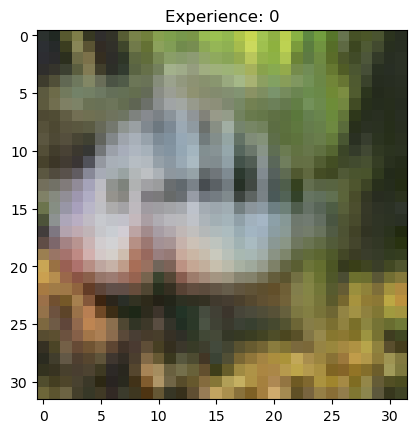

Train experience 1
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


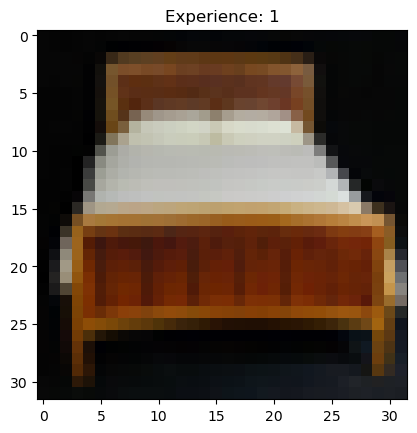

Train experience 2
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


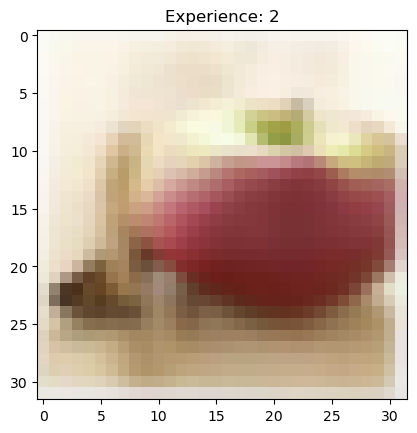

Train experience 3
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


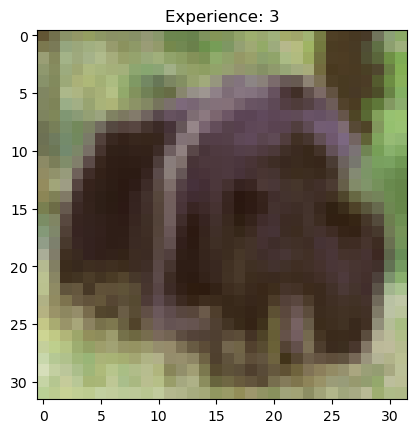

Train experience 4
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


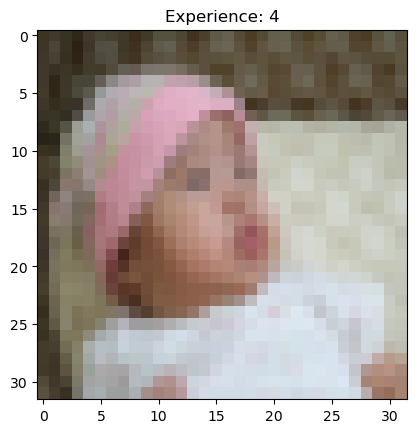

Split 110
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
The benchmark instance contains 5 training experiences.
Train experience 0
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


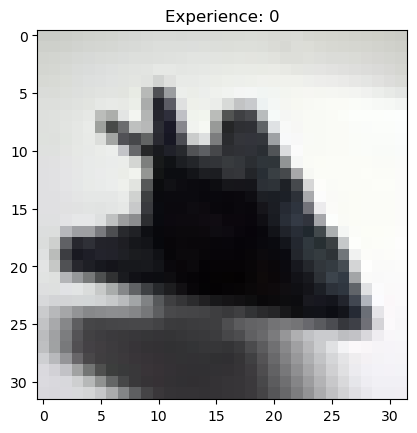

Train experience 1
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


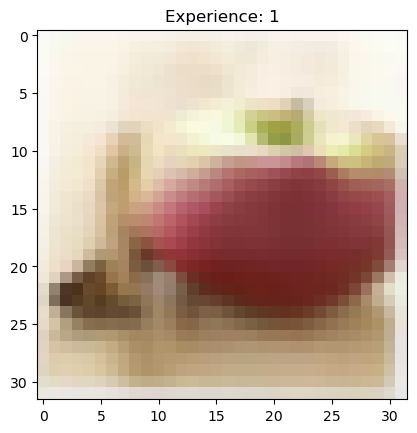

Train experience 2
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


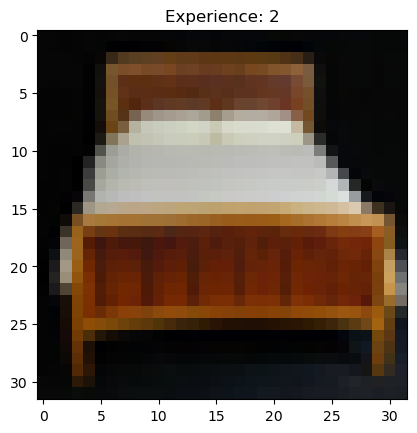

Train experience 3
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


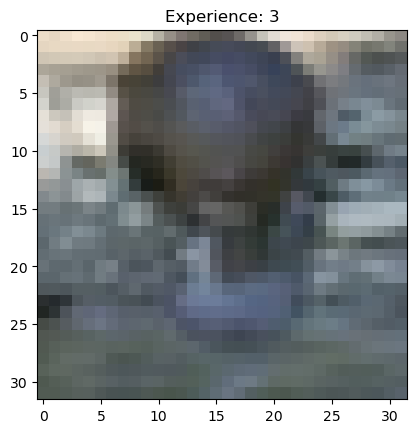

Train experience 4
X tensor: torch.Size([300, 3, 32, 32])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


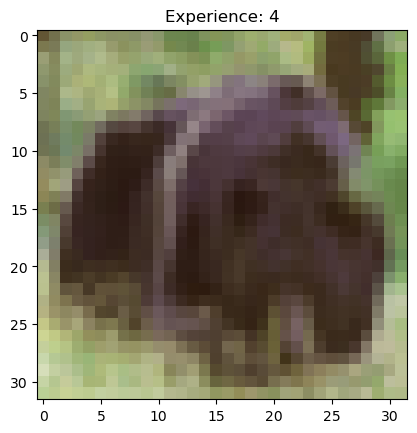

In [6]:
from typing import (
    List,
    Any,
    Sequence,
    Union,
    Optional,
    TypeVar,
    Callable,
    Dict,
    Tuple,
    Mapping,
    overload,
)
import random
from pathlib import Path
from typing import Sequence, Optional, Union, Any
from avalanche.benchmarks.utils.classification_dataset import *
from torchvision import transforms
from avalanche.benchmarks.utils.utils import (
    TaskSet,
    _count_unique,
    find_common_transforms_group,
    _init_task_labels,
    _init_transform_groups,
    _split_user_def_targets,
    _split_user_def_task_label,
    _traverse_supported_dataset,
)

from avalanche.benchmarks.classic.classic_benchmarks_utils import (
    check_vision_benchmark,
)

from avalanche.benchmarks.datasets.external_datasets.cifar import (
    get_cifar100_dataset,
    get_cifar10_dataset,
)
def _concat_taskaware_classification_datasets_sequentially(
    train_dataset_list: Sequence[ISupportedClassificationDataset],
    test_dataset_list: Sequence[ISupportedClassificationDataset],
) -> Tuple[
    TaskAwareSupervisedClassificationDataset,
    TaskAwareSupervisedClassificationDataset,
    List[list],
]:
    
    remapped_train_datasets: List[TaskAwareSupervisedClassificationDataset] = []
    remapped_test_datasets: List[TaskAwareSupervisedClassificationDataset] = []
    next_remapped_idx = 0

    train_dataset_list_sup = list(
        map(_as_taskaware_supervised_classification_dataset, train_dataset_list)
    )
    test_dataset_list_sup = list(
        map(_as_taskaware_supervised_classification_dataset, test_dataset_list)
    )
    del train_dataset_list
    del test_dataset_list

    # Obtain the number of classes of each dataset
    classes_per_dataset = [
        _count_unique(
            train_dataset_list_sup[dataset_idx].targets,
            test_dataset_list_sup[dataset_idx].targets,
        )
        for dataset_idx in range(len(train_dataset_list_sup))
    ]

    new_class_ids_per_dataset = []
    for dataset_idx in range(len(train_dataset_list_sup)):
        # Get the train and test sets of the dataset
        train_set = train_dataset_list_sup[dataset_idx]
        test_set = test_dataset_list_sup[dataset_idx]

        # Get the classes in the dataset
        dataset_classes = set(map(int, train_set.targets))

        # The class IDs for this dataset will be in range
        # [n_classes_in_previous_datasets,
        #       n_classes_in_previous_datasets + classes_in_this_dataset)
        new_classes = list(
            range(
                next_remapped_idx,
                next_remapped_idx + classes_per_dataset[dataset_idx],
            )
        )
        new_class_ids_per_dataset.append(new_classes)

        # AvalancheSubset is used to apply the class IDs transformation.
        # Remember, the class_mapping parameter must be a list in which:
        # new_class_id = class_mapping[original_class_id]
        # Hence, a list of size equal to the maximum class index is created
        # Only elements corresponding to the present classes are remapped
        class_mapping = [-1] * (max(dataset_classes) + 1)
        j = 0
        for i in dataset_classes:
            class_mapping[i] = new_classes[j]
            j += 1

        a = _taskaware_classification_subset(train_set, class_mapping=class_mapping)

        # Create remapped datasets and append them to the final list
        remapped_train_datasets.append(
            _taskaware_classification_subset(train_set, class_mapping=class_mapping)
        )
        remapped_test_datasets.append(
            _taskaware_classification_subset(test_set, class_mapping=class_mapping)
        )
        next_remapped_idx += classes_per_dataset[dataset_idx]

    return (
        _concat_taskaware_classification_datasets(remapped_train_datasets),
        _concat_taskaware_classification_datasets(remapped_test_datasets),
        new_class_ids_per_dataset,
    )

from avalanche.benchmarks import nc_benchmark, NCScenario

_default_cifar100_train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    ]
)

_default_cifar100_eval_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    ]
)


def SplitCIFAR100(
    n_experiences: int,
    *,
    first_exp_with_half_classes: bool = False,
    return_task_id=False,
    seed: Optional[int] = None,
    fixed_class_order: Optional[Sequence[int]] = None,
    shuffle: bool = True,
    class_ids_from_zero_in_each_exp: bool = False,
    class_ids_from_zero_from_first_exp: bool = False,
    train_transform: Optional[Any] = _default_cifar100_train_transform,
    eval_transform: Optional[Any] = _default_cifar100_eval_transform,
    dataset_root: Optional[Union[str, Path]] = None
):
    
    cifar_train, cifar_test = get_cifar100_dataset(dataset_root)

    return nc_benchmark(
        train_dataset=cifar_train,
        test_dataset=cifar_test,
        n_experiences=n_experiences,
        task_labels=return_task_id,
        seed=seed,
        fixed_class_order=fixed_class_order,
        shuffle=shuffle,
        per_exp_classes={0: 50} if first_exp_with_half_classes else None,
        class_ids_from_zero_in_each_exp=class_ids_from_zero_in_each_exp,
        class_ids_from_zero_from_first_exp=class_ids_from_zero_from_first_exp,
        train_transform=train_transform,
        eval_transform=eval_transform,
    )


def SplitCIFAR110(
    n_experiences: int,
    *,
    seed: Optional[int] = None,
    fixed_class_order: Optional[Sequence[int]] = None,
    class_ids_from_zero_from_first_exp: bool = False,
    train_transform: Optional[Any] = _default_cifar100_train_transform,
    eval_transform: Optional[Any] = _default_cifar100_eval_transform,
    dataset_root_cifar10: Optional[Union[str, Path]] = None,
    dataset_root_cifar100: Optional[Union[str, Path]] = None
) -> NCScenario:
    """
    Creates a CL benchmark using both the CIFAR100 and CIFAR10 datasets.

    If the datasets are not present in the computer, this method will
    automatically download and store them in the data folder.

    The CIFAR10 dataset is used to create the first experience, while the
    remaining `n_experiences-1` experiences will be created from CIFAR100.

    The returned benchmark will return experiences containing all patterns of a
    subset of classes, which means that each class is only seen "once".
    This is one of the most common scenarios in the Continual Learning
    literature. Common names used in literature to describe this kind of
    scenario are "Class Incremental", "New Classes", etc. By default,
    an equal amount of classes will be assigned to each experience.

    This generator will apply a task label 0 to all experiences.

    The benchmark instance returned by this method will have two fields,
    `train_stream` and `test_stream`, which can be iterated to obtain
    training and test :class:`Experience`. Each Experience contains the
    `dataset` and the associated task label (always 0 for this specific
    benchmark).

    The benchmark API is quite simple and is uniform across all benchmark
    generators. It is recommended to check the tutorial of the "benchmark" API,
    which contains usage examples ranging from "basic" to "advanced".

    :param n_experiences: The number of experiences for the entire benchmark.
        The first experience will contain the entire CIFAR10 dataset, while the
        other n-1 experiences will be obtained from CIFAR100.
    :param seed: A valid int used to initialize the random number generator.
        Can be None.
    :param fixed_class_order: A list of class IDs used to define the class
        order ONLY for the incremental part, which is based on cifar100. The
        classes must be in range 0-99.
        If None, value of ``seed`` will be used to define the class order for
        the incremental batches on cifar100. If non-None, ``seed`` parameter
        will be ignored. Defaults to None.
    :param class_ids_from_zero_from_first_exp: If True, original class IDs
        will be remapped so that they will appear as having an ascending
        order. For instance, if the resulting class order after shuffling
        (or defined by fixed_class_order) is [23, 34, 11, 7, 6, ...] and
        class_ids_from_zero_from_first_exp is True, then all the patterns
        belonging to class 23 will appear as belonging to class "0",
        class "34" will be mapped to "1", class "11" to "2" and so on.
        This is very useful when drawing confusion matrices and when dealing
        with algorithms with dynamic head expansion. Defaults to False.
        Mutually exclusive with the ``class_ids_from_zero_in_each_exp``
        parameter.
    :param train_transform: The transformation to apply to the training data,
        e.g. a random crop, a normalization or a concatenation of different
        transformations (see torchvision.transform documentation for a
        comprehensive list of possible transformations).
        If no transformation is passed, the default train transformation
        will be used.
    :param eval_transform: The transformation to apply to the test data,
        e.g. a random crop, a normalization or a concatenation of different
        transformations (see torchvision.transform documentation for a
        comprehensive list of possible transformations).
        If no transformation is passed, the default test transformation
        will be used.
    :param dataset_root_cifar10: The root path of the CIFAR-10 dataset.
        Defaults to None, which means that the default location for
        'cifar10' will be used.
    :param dataset_root_cifar100: The root path of the CIFAR-100 dataset.
        Defaults to None, which means that the default location for
        'cifar100' will be used.

    :returns: A properly initialized :class:`NCScenario` instance.
    """

    cifar10_train, cifar10_test = get_cifar10_dataset(dataset_root_cifar10)
    cifar100_train, cifar100_test = get_cifar100_dataset(dataset_root_cifar100)

    (
        cifar_10_100_train,
        cifar_10_100_test,
        _,
    ) = _concat_taskaware_classification_datasets_sequentially(
        [cifar10_train, cifar100_train], [cifar10_test, cifar100_test]
    )
    # cifar10 classes
    class_order = [_ for _ in range(10)]
    # if a class order is defined (for cifar100) the given class labels are
    # appended to the class_order list, adding 10 to them (since the classes
    # 0-9 are the classes of cifar10).
    if fixed_class_order is not None:
        class_order.extend([c + 10 for c in fixed_class_order])
    else:
        random.seed(seed)
        # random shuffling of the cifar100 classes (labels 10-109)
        cifar_100_class_order = random.sample(range(10, 110), 100)
        class_order.extend(cifar_100_class_order)

    return nc_benchmark(
        cifar_10_100_train,
        cifar_10_100_test,
        n_experiences=n_experiences,
        task_labels=False,
        shuffle=False,
        seed=None,
        fixed_class_order=class_order,
        class_ids_from_zero_from_first_exp=class_ids_from_zero_from_first_exp,
        per_exp_classes={0: 10},
        train_transform=train_transform,
        eval_transform=eval_transform,
    )


if __name__ == "__main__":

    print("Split 100")
    benchmark_instance = SplitCIFAR100(5)
    check_vision_benchmark(benchmark_instance)

    print("Split 110")
    benchmark_instance = SplitCIFAR110(5)
    check_vision_benchmark(benchmark_instance)




# SimpleCNN

In [7]:
class SimpleCNN(nn.Module):
    

    def __init__(self, num_classes=110):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.25),
        )
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
class SimpleCNN05(nn.Module):
    #p=0.05

    def __init__(self, num_classes=110):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.05),
        )
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
class SimpleCNN01(nn.Module):
    #p=0.01

    def __init__(self, num_classes=110):
        super(SimpleCNN01, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.01),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.01),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.01),
        )
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
class SimpleCNN64(nn.Module):
    

    def __init__(self, num_classes=110):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.05),
        )
        self.classifier = nn.Sequential(nn.Linear(128, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
from avalanche.models.simple_cnn import MTSimpleCNN

In [12]:
from torch.nn import (
    Module,
    Sequential,
    BatchNorm2d,
    Conv2d,
    ReLU,
    ConstantPad3d,
    Identity,
    AdaptiveAvgPool2d,
    Linear,
)
class IcarlNet(Module):
    def __init__(self, num_classes: int, n=5, c=3):
        super().__init__()

        self.is_train = True
        input_dims = c
        output_dims = 16

        first_conv = Sequential(
            conv3x3(input_dims, output_dims, stride=(1, 1)),
            batch_norm(16),
            ReLU(True),
        )

        input_dims = output_dims
        output_dims = 16

        # first stack of residual blocks, output is 16 x 32 x 32
        layers_list = []
        for _ in range(n):
            layers_list.append(ResidualBlock(input_dims))
        first_block = Sequential(*layers_list)

        input_dims = output_dims
        output_dims = 32

        # second stack of residual blocks, output is 32 x 16 x 16
        layers_list = [ResidualBlock(input_dims, increase_dim=True)]
        for _ in range(1, n):
            layers_list.append(ResidualBlock(output_dims))
        second_block = Sequential(*layers_list)

        input_dims = output_dims
        output_dims = 64

        # third stack of residual blocks, output is 64 x 8 x 8
        layers_list = [ResidualBlock(input_dims, increase_dim=True)]
        for _ in range(1, n - 1):
            layers_list.append(ResidualBlock(output_dims))
        layers_list.append(ResidualBlock(output_dims, last=True))
        third_block = Sequential(*layers_list)
        final_pool = AdaptiveAvgPool2d(output_size=(1, 1))

        self.feature_extractor = Sequential(
            first_conv,
            first_block,
            second_block,
            third_block,
            final_pool,
            Flatten(),
        )

        input_dims = output_dims
        output_dims = num_classes

        self.classifier = Linear(input_dims, output_dims)


    def forward(self, x):
        x = self.feature_extractor(x)  # Already flattened
        x = self.classifier(x)
        return x



In [13]:
from avalanche.models.slim_resnet18 import MLP,MTSlimResNet18

In [14]:
# """
# Same example as in all_mnist.py, but using early stopping to dynamically stop
# the training procedure when the model converged instead of training for a
# fixed number of epochs.
# IMPORTANT: In this example we use the test set to detect when the
# generalization error stops decreasing. In practice, one should *never* use
# the test set for early stopping, but rather measure the generalization
# performance on a held-out validation set.
# """

# import torch
# import argparse
# from torch.nn import CrossEntropyLoss
# from torch.optim import SGD

# from avalanche.benchmarks.classic import PermutedMNIST, RotatedMNIST, SplitMNIST
# from avalanche.models import SimpleMLP
# from avalanche.training.plugins.early_stopping import EarlyStoppingPlugin
# from avalanche.training.supervised import Naive


# def main(args):
#     # Device config
#     device = torch.device(
#         f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
#     )

#     # model
#     model = SimpleMLP(num_classes=10)

#     # Here we show all the MNIST variation we offer in the "classic" benchmarks
#     if args.mnist_type == "permuted":
#         benchmark = PermutedMNIST(n_experiences=5, seed=1)
#     elif args.mnist_type == "rotated":
#         benchmark = RotatedMNIST(
#             n_experiences=5, rotations_list=[30, 60, 90, 120, 150], seed=1
#         )
#     else:
#         benchmark = SplitMNIST(n_experiences=5, seed=1)

#     # Than we can extract the parallel train and test streams
#     train_stream = benchmark.train_stream
#     test_stream = benchmark.test_stream

#     # Prepare for training & testing
#     optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
#     criterion = CrossEntropyLoss()

#     # Continual learning strategy with default logger
#     cl_strategy = Naive(
#         model,
#         optimizer,
#         criterion,
#         train_mb_size=32,
#         train_epochs=100,
#         eval_mb_size=32,
#         device=device,
#         eval_every=1,
#         plugins=[EarlyStoppingPlugin(args.patience, "test_stream")],
#     )

#     # train and test loop
#     results = []
#     for train_task, test_task in zip(train_stream, test_stream):
#         print("Current Classes: ", train_task.classes_in_this_experience)
#         cl_strategy.train(train_task, eval_streams=[test_task])
#         results.append(cl_strategy.eval(test_stream))


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--mnist_type",
#         type=str,
#         default="split",
#         choices=["rotated", "permuted", "split"],
#         help="Choose between MNIST variations: " "rotated, permuted or split.",
#     )
#     parser.add_argument(
#         "--cuda",
#         type=int,
#         default=0,
#         help="Select zero-indexed cuda device. -1 to use CPU.",
#     )
#     parser.add_argument(
#         "--patience",
#         type=int,
#         default=3,
#         help="Number of epochs to wait without generalization"
#         "improvements before stopping the training .",
#     )
#     args = parser.parse_args()

#     main(args)

# Naive

In [13]:
"""
Example on how to use the checkpoint plugin.

This is basically a vanilla Avalanche main script, but with the checkpointing
functionality enabled. Proper comments are provided to point out the changes
required to use the checkpoint plugin.
"""
import argparse

from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger

from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Naive


def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    
    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )


    # Create the strategy (as usual)
    strategy = Naive(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
)


    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint.pkl"  # name of the checkpoint file
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--cuda",
        type=int,
        default=0,
        help="Select zero-indexed cuda device. -1 to use CPU.",
    )
    # Parse known arguments to ignore extra ones
    args, unknown = parser.parse_known_args()
    main_with_checkpointing(parser.parse_args())

usage: ipykernel_launcher.py [-h] [--cuda CUDA]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\ahmed\AppData\Roaming\jupyter\runtime\kernel-570c70f2-8a28-4cbd-b282-07d942ce5ce8.json


SystemExit: 2

C:\Users\ahmed\anaconda3\envs\DDP\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
import argparse
import sys
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy (as usual)
    strategy = Naive(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Naive.pkl"  # name of the checkpoint file
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)


    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)


Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Mapping cuda:0 to cuda:0
[InteractiveLogger] Resuming from checkpoint. Current time is 2024-08-13 11:29:48 +0100
-- >> Start of training phase << --
100%|██████████| 782/782 [00:28<00:00, 27.55it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2863
	Loss_MB/train_phase/train_stream/Task000 = 1.0757
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5557
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6875
100%|██████████| 782/782 [00:06<00:00, 116.26it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0568
	Loss_MB/train_phase/train_stream/Task000 = 0.5898
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6298
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8750
100%|██████████| 782/782 [00:06<00:00, 120.64it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 

In [18]:
import argparse
import sys
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100 
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR10(5)
    model = SimpleCNN(num_classes=10)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy (as usual)
    strategy = Naive(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Naive.pkl"  # name of the checkpoint file
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp =0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)


Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Mapping cuda:0 to cuda:0
[InteractiveLogger] Resuming from checkpoint. Current time is 2024-08-11 14:30:33 +0100
-- >> Start of training phase << --
100%|██████████| 157/157 [00:20<00:00,  7.65it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 5.0745
	Loss_MB/train_phase/train_stream/Task000 = 1.6286
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1372
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.5625
100%|██████████| 157/157 [00:01<00:00, 105.98it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0086
	Loss_MB/train_phase/train_stream/Task000 = 0.8157
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4935
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.5000
100%|██████████| 157/157 [00:01<00:00, 107.64it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7784
	Loss_MB/train_phase/train_stream/Task000 = 0.7546
	Top1_Acc_Epoch/t

In [1]:
import argparse
from avalanche.models import MlpVAE
from avalanche.training.supervised import VAETraining
from avalanche.training.plugins import GenerativeReplayPlugin

def main(args):
    # --- CONFIG
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )

    # --- BENCHMARK CREATION
    benchmark = SplitCIFAR110(n_experiences=4, seed=1234)
    # ---------

    # MODEL CREATION
    model = MlpVAE((3, 32, 32), nhid=2, device=device)

    # CREATE THE STRATEGY INSTANCE (GenerativeReplay)
    cl_strategy = VAETraining(
        model,
        torch.optim.Adam(model.parameters(), lr=0.001),
        train_mb_size=100,
        train_epochs=4,
        device=device,
        plugins=[GenerativeReplayPlugin()],
    )

    # TRAINING LOOP
    print("Starting experiment...")
    f, axarr = plt.subplots(benchmark.n_experiences, 10)
    k = 0
    for experience in benchmark.train_stream:
        print("Start of experience ", experience.current_experience)
        cl_strategy.train(experience)
        print("Training completed")

        samples = model.generate(10)
        samples = samples.detach().cpu().numpy()

        for j in range(10):
            axarr[k, j].imshow(samples[j, 0], cmap="gray")
            axarr[k, 4].set_title("Generated images for experience " + str(k))
        np.vectorize(lambda ax: ax.axis("off"))(axarr)
        k += 1

    f.subplots_adjust(hspace=1.2)
    plt.savefig("VAE_output_per_exp")
    plt.show()



parser = argparse.ArgumentParser()
parser.add_argument(
    "--cuda",
    type=int,
    default=0,
    help="Select zero-indexed cuda device. -1 to use CPU.",
)
args = parser.parse_args()
main(args)



usage: ipykernel_launcher.py [-h] [--cuda CUDA]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\ahmed\AppData\Roaming\jupyter\runtime\kernel-c29ab336-1769-4f96-96da-75267df62715.json


SystemExit: 2

C:\Users\ahmed\anaconda3\envs\DDP\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 500/500 [00:22<00:00, 22.23it/s]
Epoch 0 ended.
100%|██████████| 500/500 [00:22<00:00, 22.59it/s]
Epoch 1 ended.
100%|██████████| 500/500 [00:22<00:00, 22.27it/s]
Epoch 2 ended.
100%|██████████| 500/500 [00:22<00:00, 22.51it/s]
Epoch 3 ended.
-- >> End of training phase << --
Training completed
Start of experience  1
-- >> Start of training phase << --
100%|██████████| 125/125 [00:06<00:00, 20.10it/s]
Epoch 0 ended.
100%|██████████| 125/125 [00:05<00:00, 20.91it/s]
Epoch 1 ended.
100%|██████████| 125/125 [00:05<00:00, 20.85it/s]
Epoch 2 ended.
100%|██████████| 125/125 [00:06<00:00, 19.22it/s]
Epoch 3 ended.
-- >> End of training phase << --
Training completed
Start of experience  2
-- >> Start of training phase << --
100%|██████████| 125/1

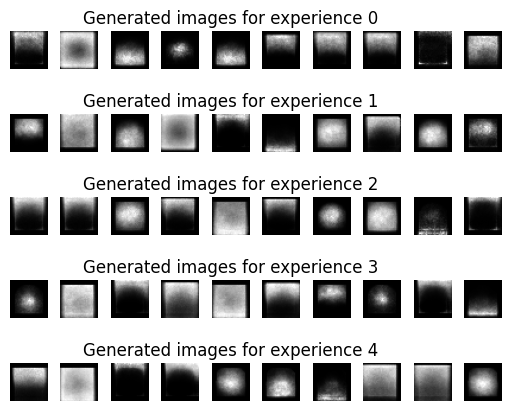

In [20]:
import argparse
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from avalanche.models import MlpVAE
from avalanche.training.supervised import VAETraining
from avalanche.training.plugins import GenerativeReplayPlugin

def main(args):
    # --- CONFIG
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )

    # --- BENCHMARK CREATION
    benchmark = SplitCIFAR110(n_experiences=5, seed=1234)
    # ---------

    # MODEL CREATION
    model = MlpVAE((3, 32, 32), nhid=2, device=device)

    # CREATE THE STRATEGY INSTANCE (GenerativeReplay)
    cl_strategy = VAETraining(
        model,
        torch.optim.Adam(model.parameters(), lr=0.001),
        train_mb_size=100,
        train_epochs=4,
        device=device,
        plugins=[GenerativeReplayPlugin()],
    )

    # TRAINING LOOP
    print("Starting experiment...")
    f, axarr = plt.subplots(benchmark.n_experiences, 10)
    k = 0
    for experience in benchmark.train_stream:
        print("Start of experience ", experience.current_experience)
        cl_strategy.train(experience)
        print("Training completed")

        samples = model.generate(10)
        samples = samples.detach().cpu().numpy()

        for j in range(10):
            axarr[k, j].imshow(samples[j, 0], cmap="gray")
            axarr[k, 4].set_title("Generated images for experience " + str(k))
        np.vectorize(lambda ax: ax.axis("off"))(axarr)
        k += 1

    f.subplots_adjust(hspace=1.2)
    plt.savefig("VAE_output_per_exp")
    plt.show()

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main(args)


In [ ]:
# The images generated by the Variational Autoencoder (VAE) model represent synthetic data that the VAE has learned to create based on its training with the CIFAR-10 and CIFAR-100 datasets. Here's a breakdown of what the images mean and what you can expect to see:

# What the Images Represent:
# Synthetic Data Generation:

# The VAE model learns to encode input images into a latent space and then decode from this latent space to reconstruct the original images.
# During the generation phase, the model samples from the latent space and decodes these samples to create new images. These new images are not copies of the training data but rather new instances that follow the learned data distribution.
# Visual Quality:

# Early in the training process, the generated images may appear blurry or noisy. This is because the VAE is still learning the data distribution.
# As training progresses, the quality of the generated images typically improves, showing more distinct and recognizable objects that resemble the training data.


# Cumulative

In [23]:
from typing import Callable, Optional, List, Union
import torch

from torch.nn import Module
from torch.optim import Optimizer

from avalanche.benchmarks.utils.utils import concat_datasets
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.training.plugins import SupervisedPlugin, EvaluationPlugin
from avalanche.training.templates import SupervisedTemplate
from avalanche.training.templates.strategy_mixin_protocol import CriterionType




class Cumulative(SupervisedTemplate):
    """Cumulative training strategy.

    At each experience, train model with data from all previous experiences
        and current experience.
    """

    def __init__(
        self,
        *,
        model: Module,
        optimizer: Optimizer,
        criterion: CriterionType,
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = None,
        device: Union[str, torch.device] = "cpu",
        plugins: Optional[List[SupervisedPlugin]] = None,
        evaluator: Union[
            EvaluationPlugin, Callable[[], EvaluationPlugin]
        ] = default_evaluator,
        eval_every=-1,
        **kwargs
    ):
        """Init.

        :param model: The model.
        :param optimizer: The optimizer to use.
        :param criterion: The loss criterion to use.
        :param train_mb_size: The train minibatch size. Defaults to 1.
        :param train_epochs: The number of training epochs. Defaults to 1.
        :param eval_mb_size: The eval minibatch size. Defaults to 1.
        :param device: The device to use. Defaults to None (cpu).
        :param plugins: Plugins to be added. Defaults to None.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        """

        super().__init__(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=train_mb_size,
            train_epochs=train_epochs,
            eval_mb_size=eval_mb_size,
            device=device,
            plugins=plugins,
            evaluator=evaluator,
            eval_every=eval_every,
            **kwargs
        )

        self.dataset = None  # cumulative dataset


    def train_dataset_adaptation(self, **kwargs):
        """
        Concatenates all the previous experiences.
        """
        exp = self.experience
        assert exp is not None
        if self.dataset is None:
            self.dataset = exp.dataset
        else:
            self.dataset = concat_datasets([self.dataset, exp.dataset])
        self.adapted_dataset = self.dataset


# P

## p=0.25

In [25]:
# p=0.25

#At each experience, train model with data from all previous experiences

import argparse
import sys
import os
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Cumulative
    strategy = Cumulative(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Cumulative.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)


Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [00:28<00:00, 26.99it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2013
	Loss_MB/train_phase/train_stream/Task000 = 1.7471
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1816
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2500
100%|██████████| 782/782 [00:07<00:00, 103.70it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8259
	Loss_MB/train_phase/train_stream/Task000 = 1.6756
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2913
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1250
100%|██████████| 782/782 [00:08<00:00, 92.40it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6499
	Loss_MB/train_phase/train_stream/Task000 = 1.7851
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3

## p=0.05

In [ ]:
# p=0.05

#At each experience, train model with data from all previous experiences

import argparse
import sys
import os
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN05(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Cumulative
    strategy = Cumulative(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Cumulative.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    # strategy, initial_exp = maybe_load_checkpoint(strategy, fname)
    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)


Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [00:30<00:00, 25.26it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2032
	Loss_MB/train_phase/train_stream/Task000 = 1.7523
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1867
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1875
100%|██████████| 782/782 [00:06<00:00, 121.73it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7518
	Loss_MB/train_phase/train_stream/Task000 = 1.6880
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3346
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2500
100%|██████████| 782/782 [00:06<00:00, 118.02it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5019
	Loss_MB/train_phase/train_stream/Task000 = 1.7215
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.

## p=0.01

In [22]:


#At each experience, train model with data from all previous experiences

import argparse
import sys
import os
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN01(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Cumulative
    strategy = Cumulative(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Cumulative.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    # strategy, initial_exp = maybe_load_checkpoint(strategy, fname)
    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)


Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
0it [00:00, ?it/s]

KeyboardInterrupt: 

In [35]:
!pip install wandb


In [25]:
!pip install --upgrade wandb


^C


# wandb

In [31]:
import wandb
print(dir(wandb))


['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [24]:
import argparse
import sys
import os
import torch
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
import wandb


from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

def main_with_checkpointing(args):
    # Initialize W&B with project and hyperparameters
    wandb.init(
        project="clcifar110",
        config={
            "learning_rate": 0.01,
            "architecture": "CNN",
            "dataset": "CIFAR-110",
            "epochs": 30,
            "batch_size": 64,
            "optimizer": "SGD"
        }
    )

    # Access W&B configuration
    config = wandb.config
    learning_rate = config.learning_rate
    epochs = config.epochs
    batch_size = config.batch_size
    optimizer_type = config.optimizer

    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True),
        loss_metrics(experience=True, stream=True),
        loggers=[InteractiveLogger(), WandBLogger()]
    )

    # Create the strategy using Cumulative
    strategy = Cumulative(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=batch_size,
        train_epochs=epochs,
        eval_mb_size=batch_size,
        device=device,
        evaluator=evaluation_plugin
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/Cumulative.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # Log metrics to W&B
        wandb.log({
            "epoch": strategy.clock.train_exp_epochs,
            "train_loss": strategy.evaluator.get_last_metrics()[f"Loss_Experience/train_phase/train_stream/Task000/Exp{train_exp.current_experience}"],
            "train_accuracy": strategy.evaluator.get_last_metrics()[f"Top1_Acc_Experience/train_phase/train_stream/Task000/Exp{train_exp.current_experience}"],
            "eval_loss": strategy.evaluator.get_last_metrics()[f"Loss_Stream/eval_phase/test_stream/Task000"],
            "eval_accuracy": strategy.evaluator.get_last_metrics()[f"Top1_Acc_Stream/eval_phase/test_stream/Task000"]
        })

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

    # Finish W&B run
    wandb.finish()

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Mapping cuda:0 to cuda:0
[InteractiveLogger] Resuming from checkpoint. Current time is 2024-07-26 11:54:30 +0100


In [ ]:
! pip install wandb --upgrade
from avalanche.logging import WandBLogger

In [22]:

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    interactive_logger = InteractiveLogger()
    wandb_logger = WandBLogger(project_name="CIFAR-110", run_name="Cumulative Method")

    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger, wandb_logger],
    )

    # Create the strategy using Cumulative
    strategy = Cumulative(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=evaluation_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Cumulative.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # Log some metrics manually to ensure they are being logged
        wandb_logger.wandb.log({"Epoch": strategy.clock.train_epoch, "Loss_Epoch": strategy.loss, "Top1_Acc_Epoch": strategy.acc})

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)


Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Mapping cuda:0 to cuda:0
[InteractiveLogger] Resuming from checkpoint. Current time is 2024-07-29 15:28:34 +0100


# Replay

In [2]:
# from avalanche.training.templates import SupervisedTemplate
# from torch.optim import Optimizer
# from avalanche.training.templates.strategy_mixin_protocol import CriterionType
# from

# class SupervisedPlugin(BaseSGDPlugin[Template], ABC):
#     """ABC for SupervisedTemplate plugins.

#     See `BaseTemplate` for complete description of the train/eval loop.
#     """

#     def __init__(self):
#         """
#         Inizializes an instance of a supervised plugin.
#         """
#         super().__init__()


# def default_evaluator() -> EvaluationPlugin:
#     return EvaluationPlugin(
#         accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
#         loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
#         loggers=default_loggers,
#     )
    
# class Replay(SupervisedTemplate):
#     """Experience replay strategy.

#     See ReplayPlugin for more details.
#     This strategy does not use task identities.
#     """

# def __init__(
#         self,
#         *,
#         model: Module,
#         optimizer: Optimizer,
#         criterion: CriterionType,
#         mem_size: int = 200,
#         train_mb_size: int = 1,
#         train_epochs: int = 1,
#         eval_mb_size: Optional[int] = None,
#         device: Union[str, torch.device] = "cpu",
#         plugins: Optional[List[SupervisedPlugin]] = None,
#         evaluator: Union[
#             EvaluationPlugin, Callable[[], EvaluationPlugin]
#         ] = default_evaluator,
#         eval_every=-1,
#         **base_kwargs
#     ):
#         """Init.

#         :param model: The model.
#         :param optimizer: The optimizer to use.
#         :param criterion: The loss criterion to use.
#         :param mem_size: replay buffer size.
#         :param train_mb_size: The train minibatch size. Defaults to 1.
#         :param train_epochs: The number of training epochs. Defaults to 1.
#         :param eval_mb_size: The eval minibatch size. Defaults to 1.
#         :param device: The device to use. Defaults to None (cpu).
#         :param plugins: Plugins to be added. Defaults to None.
#         :param evaluator: (optional) instance of EvaluationPlugin for logging
#             and metric computations.
#         :param eval_every: the frequency of the calls to `eval` inside the
#             training loop. -1 disables the evaluation. 0 means `eval` is called
#             only at the end of the learning experience. Values >0 mean that
#             `eval` is called every `eval_every` epochs and at the end of the
#             learning experience.
#         :param **base_kwargs: any additional
#             :class:`~avalanche.training.BaseTemplate` constructor arguments.
#         """

#         rp = ReplayPlugin(mem_size)
#         if plugins is None:
#             plugins = [rp]
#         else:
#             plugins.append(rp)
#         super().__init__(
#             model=model,
#             optimizer=optimizer,
#             criterion=criterion,
#             train_mb_size=train_mb_size,
#             train_epochs=train_epochs,
#             eval_mb_size=eval_mb_size,
#             device=device,
#             plugins=plugins,
#             evaluator=evaluator,
#             eval_every=eval_every,
#             **base_kwargs
#         )


In [53]:
from avalanche.training.supervised.strategy_wrappers import Replay
def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Replay
    strategy = Replay(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        mem_size=200,               # Size of the replay buffer
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [00:29<00:00, 26.08it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2030
	Loss_MB/train_phase/train_stream/Task000 = 1.7374
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1806
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2500
100%|██████████| 782/782 [00:07<00:00, 109.00it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8264
	Loss_MB/train_phase/train_stream/Task000 = 1.6992
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2902
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1250
100%|██████████| 782/782 [00:08<00:00, 88.21it/s] 
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6504
	Loss_MB/train_phase/train_stream/Task000 = 1.7631
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.

#  GenerativeReplay

In [40]:
#  GenerativeReplay:
"""
    Generative Replay Strategy

    This implements Deep Generative Replay for a Scholar consisting of a Solver
    and Generator as described in https://arxiv.org/abs/1705.08690.

    The model parameter should contain the solver. As an optional input
    a generator can be wrapped in a trainable strategy
    and passed to the generator_strategy parameter. By default a simple VAE will
    be used as generator.

    For the case where the Generator is the model itself that is to be trained,
    please simply add the GenerativeReplayPlugin() when instantiating
    your Generator's strategy.

    See GenerativeReplayPlugin for more details.
    This strategy does not use task identities.
"""

"\n    Generative Replay Strategy\n\n    This implements Deep Generative Replay for a Scholar consisting of a Solver\n    and Generator as described in https://arxiv.org/abs/1705.08690.\n\n    The model parameter should contain the solver. As an optional input\n    a generator can be wrapped in a trainable strategy\n    and passed to the generator_strategy parameter. By default a simple VAE will\n    be used as generator.\n\n    For the case where the Generator is the model itself that is to be trained,\n    please simply add the GenerativeReplayPlugin() when instantiating\n    your Generator's strategy.\n\n    See GenerativeReplayPlugin for more details.\n    This strategy does not use task identities.\n"

In [3]:
# class GenerativeReplay(SupervisedTemplate):


#     def __init__(
#         self,
#         *,
#         model: Module,
#         optimizer: Optimizer,
#         criterion: CriterionType = CrossEntropyLoss(),
#         train_mb_size: int = 1,
#         train_epochs: int = 1,
#         eval_mb_size: Optional[int] = None,
#         device: Union[str, torch.device] = "cpu",
#         plugins: Optional[List[SupervisedPlugin]] = None,
#         evaluator: Union[
#             EvaluationPlugin, Callable[[], EvaluationPlugin]
#         ] = default_evaluator,
#         eval_every=-1,
#         generator_strategy: Optional[BaseTemplate] = None,
#         replay_size: Optional[int] = None,
#         increasing_replay_size: bool = False,
#         **base_kwargs
#     ):
#         """
#         Creates an instance of Generative Replay Strategy
#         for a solver-generator pair.

#         :param model: The solver model.
#         :param optimizer: The optimizer to use.
#         :param criterion: The loss criterion to use.
#         :param train_mb_size: The train minibatch size. Defaults to 1.
#         :param train_epochs: The number of training epochs. Defaults to 1.
#         :param eval_mb_size: The eval minibatch size. Defaults to 1.
#         :param device: The device to use. Defaults to None (cpu).
#         :param plugins: Plugins to be added. Defaults to None.
#         :param evaluator: (optional) instance of EvaluationPlugin for logging
#             and metric computations.
#         :param eval_every: the frequency of the calls to `eval` inside the
#             training loop. -1 disables the evaluation. 0 means `eval` is called
#             only at the end of the learning experience. Values >0 mean that
#             `eval` is called every `eval_every` epochs and at the end of the
#             learning experience.
#         :param generator_strategy: A trainable strategy with a generative model,
#             which employs GenerativeReplayPlugin. Defaults to None.
#         :param **base_kwargs: any additional
#             :class:`~avalanche.training.BaseTemplate` constructor arguments.
#         """

#         # Check if user inputs a generator model
#         # (which is wrapped in a strategy that can be trained and
#         # uses the GenerativeReplayPlugin;
#         # see 'VAETraining" as an example below.)
#         if generator_strategy is not None:
#             self.generator_strategy = generator_strategy
#         else:
#             # By default we use a fully-connected VAE as the generator.
#             # model:
#             generator = MlpVAE((1, 28, 28), nhid=2, device=device)
#             # optimzer:
#             lr = 0.01
#             from torch.optim import Adam

#             to_optimize: List[Parameter] = list(
#                 filter(lambda p: p.requires_grad, generator.parameters())
#             )
#             optimizer_generator = Adam(
#                 to_optimize,
#                 lr=lr,
#                 weight_decay=0.0001,
#             )
#             # strategy (with plugin):
#             self.generator_strategy = VAETraining(
#                 model=generator,
#                 optimizer=optimizer_generator,
#                 criterion=VAE_loss,
#                 train_mb_size=train_mb_size,
#                 train_epochs=train_epochs,
#                 eval_mb_size=eval_mb_size,
#                 device=device,
#                 plugins=[
#                     GenerativeReplayPlugin(
#                         replay_size=replay_size,
#                         increasing_replay_size=increasing_replay_size,
#                     )
#                 ],
#             )

#         rp = GenerativeReplayPlugin(
#             generator_strategy=self.generator_strategy,
#             replay_size=replay_size,
#             increasing_replay_size=increasing_replay_size,
#         )

#         tgp = TrainGeneratorAfterExpPlugin()

#         if plugins is None:
#             plugins = [tgp, rp]
#         else:
#             plugins.append(tgp)
#             plugins.append(rp)

#         super().__init__(
#             model=model,
#             optimizer=optimizer,
#             criterion=criterion,
#             train_mb_size=train_mb_size,
#             train_epochs=train_epochs,
#             eval_mb_size=eval_mb_size,
#             device=device,
#             plugins=plugins,
#             evaluator=evaluator,
#             eval_every=eval_every,
#             **base_kwargs
#         )




In [14]:
# # Define a simple VAE generator model (example, adjust to your needs)
# class MlpVAE(nn.Module):
#     def __init__(self, input_shape, nhid, device):
#         super(MlpVAE, self).__init__()
#         self.device = device
#         self.fc1 = nn.Linear(np.prod(input_shape), nhid)
#         self.fc21 = nn.Linear(nhid, nhid)
#         self.fc22 = nn.Linear(nhid, nhid)
#         self.fc3 = nn.Linear(nhid, np.prod(input_shape))
#         self.fc4 = nn.Linear(nhid, np.prod(input_shape))
    
#     def encode(self, x):
#         h1 = F.relu(self.fc1(x.view(-1, np.prod(x.size()[1:]))))
#         return self.fc21(h1), self.fc22(h1)
    
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5*logvar)
#         eps = torch.randn_like(std)
#         return mu + eps*std
    
#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
    
#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar




In [15]:
from typing import Callable, Optional, Sequence, List, Union
import torch
from torch.nn.parameter import Parameter

from torch import sigmoid
from torch.nn import Module, CrossEntropyLoss
from torch.optim import Optimizer
from avalanche.models.packnet import PackNetModel, PackNetModule, PackNetPlugin

from avalanche.models.pnn import PNN
from avalanche.training.plugins.evaluation import (
    default_evaluator,
    default_loggers,
)
from avalanche.training.plugins import (
    SupervisedPlugin,
    CWRStarPlugin,
    ReplayPlugin,
    GenerativeReplayPlugin,
    TrainGeneratorAfterExpPlugin,
    GDumbPlugin,
    LwFPlugin,
    AGEMPlugin,
    GEMPlugin,
    EWCPlugin,
    EvaluationPlugin,
    SynapticIntelligencePlugin,
    CoPEPlugin,
    GSS_greedyPlugin,
    LFLPlugin,
    MASPlugin,
    BiCPlugin,
    MIRPlugin,
    FromScratchTrainingPlugin,
)
from avalanche.training.templates.base import BaseTemplate
from avalanche.training.templates import SupervisedTemplate
from avalanche.evaluation.metrics import loss_metrics
from avalanche.models.generator import MlpVAE, VAE_loss
from avalanche.models.expert_gate import AE_loss
from avalanche.logging import InteractiveLogger
from avalanche.training.templates.strategy_mixin_protocol import CriterionType
from avalanche.training import GenerativeReplay
from torch.optim import Adam, SGD
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
import sys
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training.plugins import EvaluationPlugin

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Define the VAE generator model and its training strategy
    generator = MlpVAE((3, 32, 32), nhid=256, device=device)
    optimizer_generator = Adam(generator.parameters(), lr=0.01, weight_decay=0.0001)
    
    # Define the VAE training strategy
    from avalanche.training.templates import SupervisedTemplate
    from avalanche.training.plugins import GenerativeReplayPlugin, TrainGeneratorAfterExpPlugin
    
    class VAETraining(SupervisedTemplate):
        # Implementation of VAE training strategy
        pass

    vae_training_strategy = VAETraining(
        model=generator,
        optimizer=optimizer_generator,
        criterion=CrossEntropyLoss(),
        train_mb_size=64,
        train_epochs=30,
        eval_mb_size=64,
        device=device,
        plugins=[GenerativeReplayPlugin(replay_size=200)],
    )

    
    # Create the Generative Replay strategy
    strategy = GenerativeReplay(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=64,
        train_epochs=30,
        eval_mb_size=64,
        device=device,
        generator_strategy=vae_training_strategy,  # The generator strategy
        replay_size=200,  # Size of the replay buffer
        increasing_replay_size=False,  # Whether to increase the replay buffer size over time
        evaluator=EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loggers=[InteractiveLogger()],
        ),
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/GenerativeReplay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [00:31<00:00, 24.71it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1973
	Loss_MB/train_phase/train_stream/Task000 = 2.2410
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1830
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 782/782 [00:07<00:00, 107.22it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8342
	Loss_MB/train_phase/train_stream/Task000 = 1.8077
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2873
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1875
100%|██████████| 782/782 [00:07<00:00, 104.27it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6508
	Loss_MB/train_phase/train_stream/Task000 = 1.5557
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

# EWC

In [ ]:
# EWC :
"""Elastic Weight Consolidation (EWC) strategy.

    See EWC plugin for details.
    This strategy does not use task identities.
    """

In [ ]:
class EWC(SupervisedTemplate):
    """Elastic Weight Consolidation (EWC) strategy.

    See EWC plugin for details.
    This strategy does not use task identities.
    """

def __init__(
        self,
        *,
        model: Module,
        optimizer: Optimizer,
        criterion: CriterionType,
        ewc_lambda: float,
        mode: str = "separate",
        decay_factor: Optional[float] = None,
        keep_importance_data: bool = False,
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = None,
        device: Union[str, torch.device] = "cpu",
        plugins: Optional[List[SupervisedPlugin]] = None,
        evaluator: Union[
            EvaluationPlugin, Callable[[], EvaluationPlugin]
        ] = default_evaluator,
        eval_every=-1,
        **base_kwargs
    ):
        """Init.

        :param model: The model.
        :param optimizer: The optimizer to use.
        :param criterion: The loss criterion to use.
        :param ewc_lambda: hyperparameter to weigh the penalty inside the total
               loss. The larger the lambda, the larger the regularization.
        :param mode: `separate` to keep a separate penalty for each previous
               experience. `onlinesum` to keep a single penalty summed over all
               previous tasks. `onlineweightedsum` to keep a single penalty
               summed with a decay factor over all previous tasks.
        :param decay_factor: used only if mode is `onlineweightedsum`.
               It specify the decay term of the importance matrix.
        :param keep_importance_data: if True, keep in memory both parameter
                values and importances for all previous task, for all modes.
                If False, keep only last parameter values and importances.
                If mode is `separate`, the value of `keep_importance_data` is
                set to be True.
        :param train_mb_size: The train minibatch size. Defaults to 1.
        :param train_epochs: The number of training epochs. Defaults to 1.
        :param eval_mb_size: The eval minibatch size. Defaults to 1.
        :param device: The device to use. Defaults to None (cpu).
        :param plugins: Plugins to be added. Defaults to None.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param base_kwargs: any additional
            :class:`~avalanche.training.BaseTemplate` constructor arguments.
        """
        ewc = EWCPlugin(ewc_lambda, mode, decay_factor, keep_importance_data)
        if plugins is None:
            plugins = [ewc]
        else:
            plugins.append(ewc)

        super().__init__(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=train_mb_size,
            train_epochs=train_epochs,
            eval_mb_size=eval_mb_size,
            device=device,
            plugins=plugins,
            evaluator=evaluator,
            eval_every=eval_every,
            **base_kwargs
        )

In [14]:
import argparse
import sys
import torch
import torchvision
from avalanche.benchmarks.datasets import CIFAR10, CIFAR100
from avalanche.benchmarks.utils import classification_dataset
import avalanche.benchmarks.scenarios.dataset_scenario

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss

from avalanche.training.supervised import (
    Cumulative, Naive, ICaRL, LwF, EWC, GenerativeReplay, JointTraining, CWRStar
)

from avalanche.evaluation.metrics import (
    Accuracy, TaskAwareAccuracy, accuracy_metrics, loss_metrics, forgetting_metrics,
    cpu_usage_metrics, gpu_usage_metrics, MAC_metrics
)
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
from avalanche.training.determinism.rng_manager import RNGManager

## ewc_lambda = 0.1

## ewc cifar10

In [16]:
from avalanche.benchmarks.classic import SplitCIFAR10
from torch.optim import SGD
import sys
import torch
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR10(5)
    model = SimpleCNN(num_classes=10)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the EWC strategy
    ewc_lambda = 0.1  # Regularization strength for EWC
    strategy = EWC(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=64,
        train_epochs=30,
        eval_mb_size=64,
        device=device,
        ewc_lambda=ewc_lambda,
        evaluator=EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loggers=[InteractiveLogger()],
        ),
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)


    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:18<00:00,  8.54it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8423
	Loss_MB/train_phase/train_stream/Task000 = 0.7008
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5753
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6875
100%|██████████| 157/157 [00:01<00:00, 105.27it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6176
	Loss_MB/train_phase/train_stream/Task000 = 0.4856
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6727
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.7500
100%|██████████| 157/157 [00:01<00:00, 107.15it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5725
	Loss_MB/train_phase/train_stream/Task000 = 0.5795
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7074
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8125
100%|██████████| 

## ewc cifar10 (ewc_lambda = 0.01)

In [15]:
from avalanche.benchmarks.classic import SplitCIFAR10
from torch.optim import SGD
import sys
import torch
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR10(5)
    model = SimpleCNN(num_classes=10)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the EWC strategy
    ewc_lambda = 0.01  # Regularization strength for EWC
    strategy = EWC(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=64,
        train_epochs=8,
        eval_mb_size=64,
        device=device,
        ewc_lambda=ewc_lambda,
        evaluator=EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loggers=[InteractiveLogger()],
        ),
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)


    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:35<00:00,  4.38it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8426
	Loss_MB/train_phase/train_stream/Task000 = 0.7041
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5758
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6875
100%|██████████| 157/157 [00:02<00:00, 53.23it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6169
	Loss_MB/train_phase/train_stream/Task000 = 0.4769
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6714
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.7500
100%|██████████| 157/157 [00:02<00:00, 53.50it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5721
	Loss_MB/train_phase/train_stream/Task000 = 0.5797
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7079
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8125
100%|██████████| 15

## ewc cifar10 (ewc_lambda = 100)

In [15]:
from avalanche.benchmarks.classic import SplitCIFAR10
from torch.optim import SGD
import sys
import torch
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR10(5)
    model = SimpleCNN(num_classes=10)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the EWC strategy
    ewc_lambda = 100  # Regularization strength for EWC
    strategy = EWC(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=64,
        train_epochs=8,
        eval_mb_size=64,
        device=device,
        ewc_lambda=ewc_lambda,
        evaluator=EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loggers=[InteractiveLogger()],
        ),
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)


    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:25<00:00,  6.15it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8421
	Loss_MB/train_phase/train_stream/Task000 = 0.7030
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5763
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6875
100%|██████████| 157/157 [00:01<00:00, 85.78it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6165
	Loss_MB/train_phase/train_stream/Task000 = 0.4820
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6730
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.7500
100%|██████████| 157/157 [00:01<00:00, 87.28it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5718
	Loss_MB/train_phase/train_stream/Task000 = 0.5924
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7094
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8125
100%|██████████| 15

## ewc cifar10 (ewc_lambda = 50)

In [16]:
from avalanche.benchmarks.classic import SplitCIFAR10
from torch.optim import SGD
import sys
import torch
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR10(5)
    model = SimpleCNN(num_classes=10)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the EWC strategy
    ewc_lambda = 50  # Regularization strength for EWC
    strategy = EWC(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=64,
        train_epochs=8,
        eval_mb_size=64,
        device=device,
        ewc_lambda=ewc_lambda,
        evaluator=EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loggers=[InteractiveLogger()],
        ),
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)


    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:18<00:00,  8.37it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8417
	Loss_MB/train_phase/train_stream/Task000 = 0.7035
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5770
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6875
100%|██████████| 157/157 [00:01<00:00, 102.71it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6160
	Loss_MB/train_phase/train_stream/Task000 = 0.4684
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6716
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8125
100%|██████████| 157/157 [00:01<00:00, 104.24it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5726
	Loss_MB/train_phase/train_stream/Task000 = 0.5980
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7082
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8125
100%|██████████| 

## ewc cifar100

In [17]:
from avalanche.benchmarks.classic import SplitCIFAR100
from torch.optim import SGD
import sys
import torch
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR100(5)
    model = SimpleCNN(num_classes=100)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the EWC strategy
    ewc_lambda = 0.1  # Regularization strength for EWC
    strategy = EWC(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_mb_size=64,
        train_epochs=30,
        eval_mb_size=64,
        device=device,
        ewc_lambda=ewc_lambda,
        evaluator=EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            loggers=[InteractiveLogger()],
        ),
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)


    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:18<00:00,  8.51it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4880
	Loss_MB/train_phase/train_stream/Task000 = 2.9142
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0501
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0625
100%|██████████| 157/157 [00:01<00:00, 102.55it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.8692
	Loss_MB/train_phase/train_stream/Task000 = 2.9653
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1032
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0625
100%|██████████| 157/157 [00:01<00:00, 102.38it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.6828
	Loss_MB/train_phase/train_stream/Task000 = 2.3544
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1489
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1875
100%|██████████| 

# Size of the replay buffer

## Size of the replay buffer = 2000

In [15]:
# Size of the replay buffer = 2000
from avalanche.training.supervised.strategy_wrappers import Replay
def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Replay
    strategy = Replay(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        mem_size=2000,               # Size of the replay buffer
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    # STEP 3: USE THE "initial_exp" to resume training
    initial_exp=0
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [00:33<00:00, 23.30it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2045
	Loss_MB/train_phase/train_stream/Task000 = 1.7487
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1794
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1875
100%|██████████| 782/782 [00:07<00:00, 109.47it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8304
	Loss_MB/train_phase/train_stream/Task000 = 1.6864
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2883
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0625
100%|██████████| 782/782 [00:07<00:00, 111.56it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6510
	Loss_MB/train_phase/train_stream/Task000 = 1.8016
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.

## Size of the replay buffer = 5000

In [16]:
# Size of the replay buffer = 5000
import sys
from avalanche.training.supervised.strategy_wrappers import Replay
def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR110(6)
    model = SimpleCNN(num_classes=110)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Replay
    strategy = Replay(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        mem_size=5000,               # Size of the replay buffer
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    # STEP 3: USE THE "initial_exp" to resume training
    initial_exp=0
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 782/782 [00:28<00:00, 27.12it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2028
	Loss_MB/train_phase/train_stream/Task000 = 1.7332
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1816
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1875
100%|██████████| 782/782 [00:08<00:00, 93.20it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8276
	Loss_MB/train_phase/train_stream/Task000 = 1.7671
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2909
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0625
100%|██████████| 782/782 [00:08<00:00, 89.45it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6578
	Loss_MB/train_phase/train_stream/Task000 = 1.9236
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.37

# test statistique 

In [ ]:
import numpy as np
from scipy.stats import mannwhitneyu

# Example data for dropout = 0.05
accuracies_005 = np.random.rand(8, 5, 5)  # Replace with your actual data
# Example data for dropout = 0.01
accuracies_001 = np.random.rand(8, 5, 5)  # Replace with your actual data

# Flatten the 3D arrays into 1D arrays
flattened_005 = accuracies_005.flatten()
flattened_001 = accuracies_001.flatten()

# Perform the Mann-Whitney U test
result = mannwhitneyu(x=flattened_005, y=flattened_001, alternative='two-sided')

# Output the results
print(f"Statistic: {result.statistic}, p-value: {result.pvalue}")


# replay with different model (p=0.05 , size of buffer = 2000)

## with simpleCNN64

In [21]:
class SimpleCNN64(nn.Module):
    #p=0.05

    def __init__(self, num_classes=100):
        super(SimpleCNN64, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.05),
        )
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [23]:
from avalanche.training.supervised.strategy_wrappers import Replay

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR100(5)
    model = SimpleCNN64(num_classes=100)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Replay
    strategy = Replay(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        mem_size=2000,               # Size of the replay buffer
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:22<00:00,  7.02it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.5424
	Loss_MB/train_phase/train_stream/Task000 = 3.0843
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0421
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 157/157 [00:05<00:00, 26.97it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.8241
	Loss_MB/train_phase/train_stream/Task000 = 2.5218
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1068
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.2500
100%|██████████| 157/157 [00:06<00:00, 25.01it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.6274
	Loss_MB/train_phase/train_stream/Task000 = 2.4026
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1685
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.3125
100%|██████████| 15

## with simpleCNN128

In [24]:
class SimpleCNN128(nn.Module):
    #p=0.05

    def __init__(self, num_classes=110):
        super(SimpleCNN128, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.05),
        )
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
from avalanche.training.supervised.strategy_wrappers import Replay

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR100(5)
    model = SimpleCNN128(num_classes=100)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Replay
    strategy = Replay(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        mem_size=2000,               # Size of the replay buffer
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

## with simpleCNN32

In [19]:
class SimpleCNN32(nn.Module):
    #p=0.05

    def __init__(self, num_classes=100):
        super(SimpleCNN32, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.05),
        )
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [20]:
from avalanche.training.supervised.strategy_wrappers import Replay

def main_with_checkpointing(args):
    # STEP 1: SET THE RANDOM SEEDS to guarantee reproducibility
    RNGManager.set_random_seeds(1234)

    # Nothing new here...
    device = torch.device(
        f"cuda:{args.cuda}" if torch.cuda.is_available() and args.cuda >= 0 else "cpu"
    )
    print("Using device", device)

    # CL Benchmark Creation (as usual)
    benchmark = SplitCIFAR100(5)
    model = SimpleCNN32(num_classes=100)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = CrossEntropyLoss()

    # Create the evaluation plugin (as usual)
    evaluation_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
    )

    # choose some metrics and evaluation method
    interactive_logger = InteractiveLogger()
    eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
        loggers=[interactive_logger],
    )

    # Create the strategy using Replay
    strategy = Replay(
        model=model,                # Ensure your model is capable of handling the increased number of classes
        optimizer=optimizer,        # Optimizer, e.g., Adam or SGD
        criterion=criterion,        # Loss function, e.g., CrossEntropyLoss
        mem_size=2000,               # Size of the replay buffer
        train_mb_size=64,           # Batch size; adjust based on your hardware and model requirements
        train_epochs=30,            # Increased number of epochs to ensure adequate training
        eval_mb_size=64,            # Evaluation batch size
        device=device,              # Device, e.g., 'cuda' or 'cpu'
        evaluator=eval_plugin # Evaluation plugin or metric, e.g., accuracy
    )

    # STEP 2: TRY TO LOAD THE LAST CHECKPOINT
    # if the checkpoint exists, load it into the newly created strategy
    # the method also loads the experience counter, so we know where to
    # resume training
    fname = "./checkpoint/Replay.pkl"  # name of the checkpoint file
    os.makedirs(os.path.dirname(fname), exist_ok=True)  # Ensure the checkpoint directory exists
    #strategy, initial_exp = maybe_load_checkpoint(strategy, fname)

    initial_exp=0
    # STEP 3: USE THE "initial_exp" to resume training
    for train_exp in benchmark.train_stream[initial_exp:]:
        strategy.train(train_exp, num_workers=4, persistent_workers=True)
        strategy.eval(benchmark.test_stream, num_workers=4)

        # STEP 4: SAVE the checkpoint after training on each experience.
        save_checkpoint(strategy, fname)

if __name__ == "__main__":
    if 'ipykernel_launcher' in sys.argv[0]:
        # Running in a Jupyter environment
        class Args:
            cuda = 0
        args = Args()
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "--cuda",
            type=int,
            default=0,
            help="Select zero-indexed cuda device. -1 to use CPU.",
        )
        # Parse known arguments and ignore the rest
        args, _ = parser.parse_known_args(sys.argv)
    main_with_checkpointing(args)

Using device cuda:0
Files already downloaded and verified
Files already downloaded and verified
-- >> Start of training phase << --
100%|██████████| 157/157 [00:25<00:00,  6.23it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.5174
	Loss_MB/train_phase/train_stream/Task000 = 2.9440
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0583
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0625
100%|██████████| 157/157 [00:01<00:00, 85.49it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.8249
	Loss_MB/train_phase/train_stream/Task000 = 2.9659
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1069
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1250
100%|██████████| 157/157 [00:01<00:00, 88.79it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.6808
	Loss_MB/train_phase/train_stream/Task000 = 2.4878
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1494
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0625
100%|██████████| 15